<a href="https://colab.research.google.com/github/yunming-lpf/DeepModels/blob/master/VAE_mnist_tf1.3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from tensorflow.keras import *

class Sampling(layers.Layer):
  def call(self, inputs):
    z_mean, z_log_var = inputs
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon
  

class Encoder(layers.Layer):
  def __init__(self, latent_dim=32, intermediate_dim=64, name='encoder', **kwargs):
    super(Encoder, self).__init__(name=name, **kwargs)
    self.dense_proj = layers.Dense(intermediate_dim, activation='relu')
    self.dense_mean = layers.Dense(latent_dim)
    self.dense_log_var = layers.Dense(latent_dim)
    self.sampling = Sampling()
    
  def call(self, inputs):
    h1 = self.dense_proj(inputs)
    z_mean = self.dense_mean(h1)
    z_log_var = self.dense_log_var(h1)
    z = self.sampling((z_mean, z_log_var))
    return z_mean, z_log_var, z

  
class Decoder(layers.Layer):
  def __init__(self, original_dim, intermediate_dim=64, name='decoder', **kwargs):
    super(Decoder, self).__init__(name=name, **kwargs)
    self.dense_proj = layers.Dense(intermediate_dim, activation='relu')
    self.dense_output = layers.Dense(original_dim, activation='sigmoid')
    
  def call(self, inputs):
    h1 = self.dense_proj(inputs)
    return self.dense_output(h1)
  
  
class VariationalAutoEncoder(Model):
  def __init__(self, original_dim, latent_dim=32, intermediate_dim=64, name='variational_auto_encoder', **kwargs):
    super(VariationalAutoEncoder, self).__init__(name=name, **kwargs)
    self.encoder = Encoder(latent_dim, intermediate_dim)
    self.decoder = Decoder(original_dim, intermediate_dim)
    
  def call(self, inputs):
    z_mean, z_log_var, z = self.encoder(inputs)
    pred = self.decoder(z)
    kl_loss = -0.5 * tf.reduce_sum(1+ z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
    self.add_loss(kl_loss)
    return pred
  
original_dim = 784
learning_rate = 1e-3
latent_dim=2
intermediate_dim=256
buff_size = 60000
batch_size = 100
epochs = 150

#构建模型
inputs = layers.Input(shape=(original_dim,))
encoder = Encoder(latent_dim, intermediate_dim)
z_mean, z_log_var, z = encoder(inputs)
decoder = Decoder(original_dim, intermediate_dim)
pred = decoder(z)
vae_model = Model(inputs, pred)

#生成损失
kl_loss = -0.5 * tf.reduce_sum(1+ z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
xent_loss = original_dim * losses.BinaryCrossentropy()(inputs, pred)
vae_loss = tf.reduce_mean(kl_loss + xent_loss)

vae_model.add_loss(vae_loss)
vae_model.compile(optimizer=optimizers.Adam(learning_rate))

#train_set, train_set = get_mnist_dataset(batch_size, buff_size)
(x_train, y_train), (x_test, y_test) = datasets.mnist.load_data(path='mnist.npz')
train_set = x_train.reshape(x_train.shape[0], original_dim)/256
test_set = x_test.reshape(x_test.shape[0], original_dim)/256

vae_model.fit(train_set, 
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(test_set, None))
vae_model.summary()


# 构建生成器
decoder_input = Input(shape=(latent_dim,))
decoder_pred = decoder(decoder_input)
generator = Model(decoder_input, decoder_pred)



Train on 60000 samples, validate on 10000 samples
Epoch 1/150
60000/60000 [==============================] - 11s 176us/sample - loss: 197.3280 - val_loss: 171.7971
Epoch 2/150
60000/60000 [==============================] - 9s 158us/sample - loss: 169.3045 - val_loss: 167.7623
Epoch 3/150
60000/60000 [==============================] - 9s 157us/sample - loss: 166.1075 - val_loss: 165.2635
Epoch 4/150
60000/60000 [==============================] - 9s 158us/sample - loss: 163.9062 - val_loss: 163.3213
Epoch 5/150
60000/60000 [==============================] - 10s 161us/sample - loss: 162.0675 - val_loss: 161.6025
Epoch 6/150
60000/60000 [==============================] - 10s 159us/sample - loss: 160.5875 - val_loss: 160.3709
Epoch 7/150
60000/60000 [==============================] - 9s 158us/sample - loss: 159.4340 - val_loss: 159.3700
Epoch 8/150
60000/60000 [==============================] - 9s 156us/sample - loss: 158.4950 - val_loss: 158.4495
Epoch 9/150
60000/60000 [==================

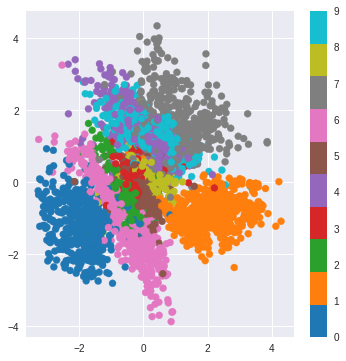

In [52]:
#各label在隐变量空间的分布
inferencer = Model(inputs, z_mean)
x_pred = inferencer.predict(test_set, batch_size=batch_size)
pred_set = np.concatenate((x_pred, np.reshape(y_test,(len(y_test),1))), axis=1)
np.random.shuffle(pred_set)

plt.figure(figsize=(6, 6))
plt.scatter(pred_set[:5000, 0], pred_set[:5000, 1], c=pred_set[:5000, 2], cmap='tab10')
plt.colorbar()
plt.show()

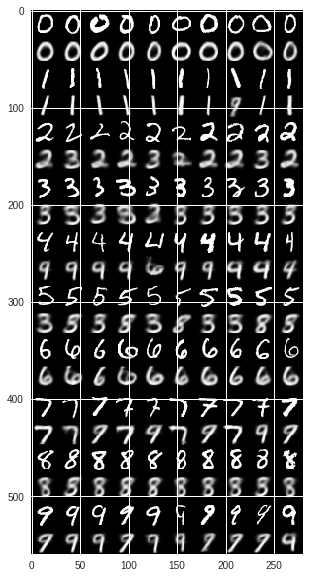

In [53]:
#测试集中图片选取
test_dict = {}
for (x, y) in zip(list(test_set), list(y_test)):
  if y in test_dict:
    test_dict[y].append(x)
  else:
    test_dict[y] = []

figure = np.zeros((digit_size * 20, digit_size * 10))

#对比原始图片和生成图片
for y in range(10):
  samples = np.array(test_dict[y][:10])
  j = 0
  for orgimg, predimg in zip(samples, vae_model.predict(samples)):
    orgimg = orgimg.reshape(digit_size, digit_size)
    predimg = predimg.reshape(digit_size, digit_size)
    figure[2*y * digit_size: (2*y+1) * digit_size,
           j * digit_size: (j + 1) * digit_size] = orgimg
    figure[(2*y+1) * digit_size: (2*y+2) * digit_size,
           j * digit_size: (j + 1) * digit_size] = predimg
    j += 1

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()


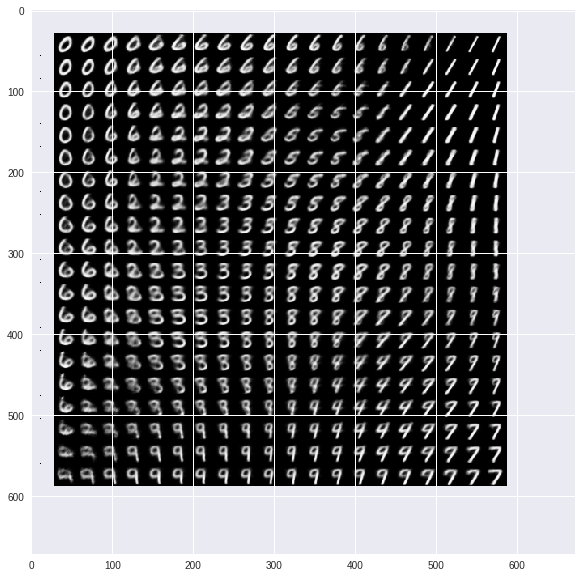

In [54]:
num_examples = 24
digit_size = 28
figure = np.zeros((digit_size * num_examples, digit_size * num_examples))

#构造隐变量
grid_x = norm.ppf(np.linspace(0, 1.1, num_examples))
grid_y = norm.ppf(np.linspace(0, 1.1, num_examples))

#展示隐变量空间对应的输出
for i, yi in enumerate(grid_x):
  for j, xi in enumerate(grid_y):
      z_sample = np.array([[xi, yi]])
      x_decoded = generator.predict(z_sample)
      digit = x_decoded[0].reshape(digit_size, digit_size)
      figure[i * digit_size: (i + 1) * digit_size,
             j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()
